# Guided Project: Answering Business Questions using SQL

### In the following notebook we will try to answer some basic business questions using python and sql querys

#### We will use chinook.db file as our database

In [6]:
#imports
import pandas as pd
import sqlite3
import matplotlib as mp
%matplotlib inline

#### Defining some basic functions

In [7]:
def run_query(q):
        with sqlite3.connect('chinook.db') as conn:
            return pd.read_sql(q, conn)

In [8]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        c = conn.cursor()
        c.execute(q)

In [15]:
def show_tables():
    q = ("""SELECT
    name,
    type
    FROM sqlite_master
    WHERE type IN ("table","view");""")
    return run_query(q)

In [16]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We will need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

In [255]:
q = ("""WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;""")
run_query(q)
absolute_number_sold = run_query(q)

In [257]:
sum_sold = sum(absolute_number_sold.tracks_sold)
print (sum_sold)

1017


In [259]:
absolute_number_sold['percent'] = round(((absolute_number_sold['tracks_sold'] / sum_sold)*100),1)


In [260]:
absolute_number_sold

,genre,tracks_sold,percentage_sold,percent
0,Rock,561,0.533777,55.2
1,Alternative & Punk,130,0.123692,12.8
2,Metal,124,0.117983,12.2
3,R&B/Soul,53,0.050428,5.2
4,Blues,36,0.034253,3.5
5,Alternative,35,0.033302,3.4
6,Latin,22,0.020932,2.2
7,Pop,22,0.020932,2.2
8,Hip Hop/Rap,20,0.019029,2.0
9,Jazz,14,0.013321,1.4


### As we can see Rock,Alternative & Punk and Metal are the most famous genres

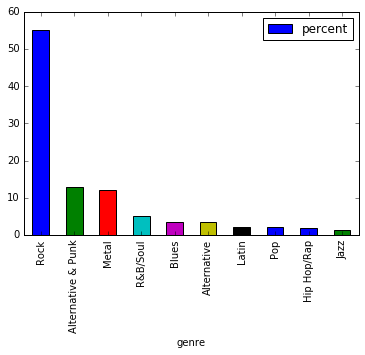

In [261]:
absolute_number_sold.plot(kind='bar',x='genre',y='percent')

### We will write a query that finds the total dollar amount of sales assigned to each sales support agent within the company.

In [145]:
q = ("""

with emp as(
select em.first_name|| " " ||em.last_name as full_name,
count(cus.customer_id) sales_ammount ,
sum(inv.total) as dollar_ammount,
(select first_name|| " " ||last_name from employee where employee_id = em.reports_to  ) report_to 

from employee as em 
left join customer cus on cus.support_rep_id = em.employee_id
left join invoice inv on inv.customer_id = cus.customer_id
group by full_name 
order by full_name)

select * from emp

""")

run_query(q)
sales_agent_ammount=run_query(q)

In [146]:
sales_agent_ammount

,full_name,sales_ammount,dollar_ammount,report_to
0,Andrew Adams,0,NaN,None
1,Jane Peacock,212,1731.51,Nancy Edwards
2,Laura Callahan,0,NaN,Michael Mitchell
3,Margaret Park,214,1584.00,Nancy Edwards
4,Michael Mitchell,0,NaN,Andrew Adams
5,Nancy Edwards,0,NaN,Andrew Adams
6,Robert King,0,NaN,Michael Mitchell
7,Steve Johnson,188,1393.92,Nancy Edwards


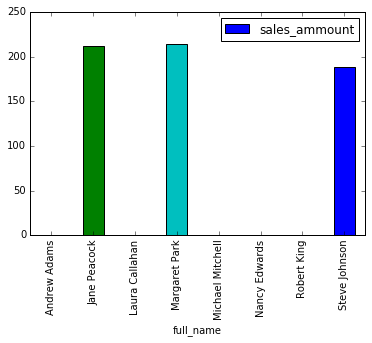

In [147]:
sales_agent_ammount.plot(kind='bar',x='full_name',y='sales_ammount')

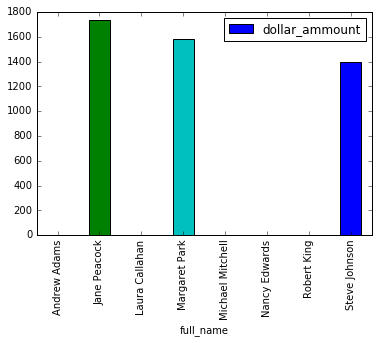

In [148]:
sales_agent_ammount.plot(kind='bar',x='full_name',y='dollar_ammount')

### As we can see only three employees are really sales support agent

## Lets write a query that collects data on purchases from different countries.

In [240]:
q= ("drop view cnt")
run_command(q)

In [241]:
q = ("""

CREATE view cnt AS
    select
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = cus.country
                ) = 1 THEN "Other"
           ELSE cus.country
       END AS country,
    count(DISTINCT cus.customer_id) as customers,
    count(inv.invoice_id) as orders,
    sum(inv.total) as total_value,
    sum(inv.total)/count(DISTINCT cus.customer_id) as avg_customer_value,
    sum(inv.total)/count(inv.invoice_id) as avg_order_value
    from invoice inv
    left join customer cus on inv.customer_id = cus.customer_id
    group by country
    order by total_value desc;

""")
run_command(q)

In [262]:
q = ("""
with grouped as (
select country ,
sum(customers) customers ,
sum(total_value) total_value,
sum(total_value)/sum(customers) avg_customer_value,
sum(total_value)/sum(orders) avg_order_value
from cnt
group by country)

SELECT
    *
FROM
    (
    SELECT
        t5.*,
        CASE
            WHEN t5.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM grouped t5
   )
ORDER BY sort ASC, total_value DESC


                
""")
run_query(q)
countries_stats = run_query(q)

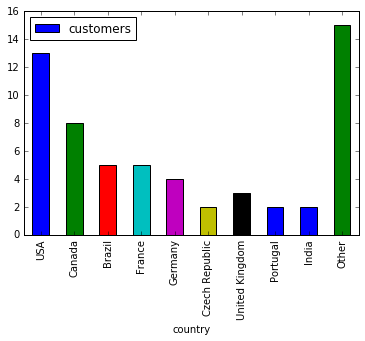

In [263]:
countries_stats.plot(kind='bar',x='country',y='customers')

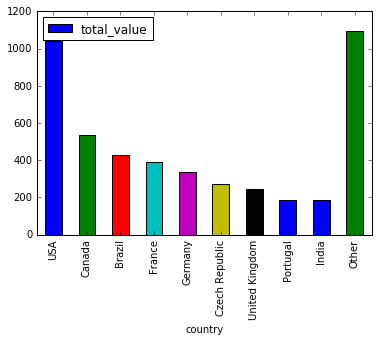

In [264]:
countries_stats.plot(kind='bar',x='country',y='total_value')

### Most customers are from USA and CANADA 

### We will write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:  Number of invoices , Percentage of invoices

In [266]:
q = ("""WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
""")
run_query(q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
